In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import files
uploads = files.upload()

Saving data.zip to data.zip


# P12 Preprocessing

In [3]:
import zipfile
import os

zip_file_name = "/content/data.zip"
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
dataset_folders = ['set-a', 'set-b', 'set-c']
data_folder_path = '/content/data'

dfs = []
parameters = set()
dfs_with_filenames = []

for dataset_folder in dataset_folders:
  features_folder_path = os.path.join(data_folder_path, dataset_folder)
  if not os.path.exists(features_folder_path):
    continue  # Skip if folder does not exist
  sorted_file_names = sorted(os.listdir(features_folder_path))
  for file_name in sorted_file_names:
    file_path = os.path.join(features_folder_path, file_name)
    if file_name.endswith('.txt'):
      df = pd.read_csv(file_path)
      parameters.update(df['Parameter'].unique())
      dfs_with_filenames.append((file_name, df))

final_df = pd.DataFrame(dfs_with_filenames, columns=['FileName', 'DataFrame'])
unique_parameters = list(parameters)

In [5]:
labels_path_a = 'data/Outcomes-a.txt'
labels_path_b = 'data/Outcomes-b.txt'
labels_path_c = 'data/Outcomes-c.txt'

labels_df_a = pd.read_csv(labels_path_a)
labels_df_b = pd.read_csv(labels_path_b)
labels_df_c = pd.read_csv(labels_path_c)

labels_df = pd.concat([labels_df_a, labels_df_b, labels_df_c], ignore_index=True)
labels_df['labels'] = labels_df.apply(lambda row: np.array(row[5:]), axis=1)
labels_df['RecordID'] = labels_df['RecordID'].astype(str).map(lambda row: row+".txt")
merged_df = pd.merge(final_df, labels_df, left_on='FileName', right_on='RecordID', how='inner')

print(merged_df.head())  # Display the first few rows of the updated dataframe


     FileName                                          DataFrame    RecordID  \
0  132539.txt        Time Parameter      Value
0    00:00  Re...  132539.txt   
1  132540.txt        Time Parameter      Value
0    00:00  Re...  132540.txt   
2  132541.txt        Time Parameter     Value
0    00:00  Rec...  132541.txt   
3  132543.txt        Time  Parameter      Value
0    00:00   ...  132543.txt   
4  132545.txt        Time  Parameter     Value
0    00:00   R...  132545.txt   

   SAPS-I  SOFA  Length_of_stay  Survival  In-hospital_death labels  
0       6     1               5        -1                  0    [0]  
1      16     8               8        -1                  0    [0]  
2      21    11              19        -1                  0    [0]  
3       7     1               9       575                  0    [0]  
4      17     2               4       918                  0    [0]  


In [7]:
from copy import deepcopy

new_df = deepcopy(merged_df)

df1 = new_df[new_df['labels']==0]
df2 = new_df[new_df['labels']==1]

concat_df = pd.concat([df2], ignore_index=True)
concat_df = pd.concat([df1, concat_df]).sample(frac=1)


In [8]:
dfs = concat_df['DataFrame'].tolist()  #merged_df['DataFrame'].tolist()

In [9]:
print(len(dfs))

11997


In [10]:
i = 0
parameter_to_idx = {}
for parameter in unique_parameters:
  parameter_to_idx[parameter] = i
  i = i+1

In [11]:
def time_to_hours(time_str):
  hours, minutes = map(int, time_str.split(':'))
  total_hours = hours + minutes / 60.0
  return total_hours

In [12]:
import numpy as np

# Initialize lists to store processed datasets and basic data
updated_dfs = []
basic_data = []

# Get the number of unique parameters
parameters_size = len(unique_parameters)

# Define the desired number of time intervals per dataset
times_threshold = 49

# Variable to track the maximum number of time groups across all dataframes
max_times = 0

# Loop through each dataframe in the list
for df in dfs:
    value_array = []
    delta_array = []
    mask_array = []
    dataset = []

    # Group the dataframe by 'Time' to process data for each time interval
    time_groups = df.groupby('Time')
    n_times = time_groups.ngroups

    # Update the maximum number of time groups encountered
    if max_times < n_times:
        max_times = n_times

    # Initialize an array to store the last available times for each parameter
    last_available_times = np.array(["00:00"] * parameters_size)
    count = 0

    # Iterate over each time group (up to times_threshold or all available times)
    for time, group in time_groups:
        values = np.zeros(parameters_size)
        deltas = np.zeros(parameters_size)
        mask = np.zeros(parameters_size)

        # Iterate over rows within the time group to extract parameter values
        for index, row in group.iterrows():
            parameter_idx = parameter_to_idx[row['Parameter']]
            values[parameter_idx] = row['Value']
            mask[parameter_idx] = 1

        # Compute deltas (time differences) for each parameter relative to last available times
        for i in range(parameters_size):
            deltas[i] = time_to_hours(time) - time_to_hours(last_available_times[i])
            if mask[i] == 1:
                last_available_times[i] = time

        # Append values, deltas, and mask arrays to respective lists
        value_array.append(values)
        delta_array.append(deltas)
        mask_array.append(mask)
        count += 1

        # Break the loop if we reach the desired times_threshold
        if count == times_threshold:
            break

    # Pad the arrays with zeros to ensure consistent length (times_threshold)
    while count < times_threshold:
        value_array.append(np.zeros(parameters_size))
        delta_array.append(np.zeros(parameters_size))
        mask_array.append(np.zeros(parameters_size))
        count += 1

    # Convert lists to numpy arrays and transpose to get desired format
    value_array = np.array(value_array).T
    delta_array = np.array(delta_array).T
    mask_array = np.array(mask_array).T

    # Append processed dataset to updated_dfs and basic_data lists
    dataset.append(value_array)
    dataset.append(mask_array)
    dataset.append(delta_array)
    updated_dfs.append(dataset)
    basic_data.append(value_array)

# Print the maximum number of time groups encountered
print("Max Time Groups:", max_times)


Max Time Groups: 216


In [13]:
print(len(basic_data))

11997


In [14]:
print(len(basic_data[1]))

43


# Mean Imputation

In [15]:
def get_mean(parameter_values):
  return np.mean(parameter_values)

In [16]:
import numpy as np
import copy

# Function to compute mean excluding zeros (assuming zeros are missing data)
def get_mean(parameter_data):
    valid_data = parameter_data[parameter_data != 0]
    if valid_data.size == 0:
        return 0  # Return 0 if all values are zero or empty to prevent division by zero in mean calculation
    return np.mean(valid_data)

# Assuming basic_data is already defined and filled
mean_dataset = copy.deepcopy(basic_data)

# Fill missing values with the mean of each parameter and normalize
for data in mean_dataset:
    for parameter_idx in range(parameters_size):
        parameter_data = np.array(data[parameter_idx])
        mean_value = get_mean(parameter_data)
        missing_indices = np.where(parameter_data == 0)
        parameter_data[missing_indices] = mean_value
        data[parameter_idx] = parameter_data

        # Normalize the data
        mean_of_data = np.mean(parameter_data)  # Calculate mean
        std_of_data = np.std(parameter_data)  # Calculate standard deviation
        if std_of_data > 0:
            # Avoid division by zero if standard deviation is zero
            data[parameter_idx] = (parameter_data - mean_of_data) / std_of_data
        else:
            # If standard deviation is zero, set data to 0 as all values are the same
            data[parameter_idx] = np.zeros_like(parameter_data)

In [ ]:
dataset_df = pd.DataFrame({'features': mean_dataset})
dataset_df['labels'] = labels_df['labels'].reset_index(drop=True)

In [ ]:
minority_rows = dataset_df[dataset_df['labels'] == 1]
replication_factor = 4
replicated_minority_rows = pd.concat([minority_rows] * replication_factor, ignore_index=True)
balanced_dataset_df = pd.concat([dataset_df, replicated_minority_rows], ignore_index=True)
balanced_dataset_df = balanced_dataset_df.sample(frac=1).reset_index(drop=True)

final_dataset_df = pd.concat([balanced_dataset_df] * replication_factor, ignore_index=True)
# Print out the new class distribution
print(final_dataset_df['labels'].value_counts())

labels
[0]    27444
[1]    22780
Name: count, dtype: int64


In [ ]:
print(len(mean_dataset[0]))

43


# Forward Imputation

In [17]:
forward_dataset = copy.deepcopy(basic_data)
for data in forward_dataset:
  for parameter_idx in range(parameters_size):
    n_times = len(data[parameter_idx])
    last_value = 0
    for n_time in range(n_times):
      if (n_time==0 and data[parameter_idx][0] == 0):
        continue
      if (data[parameter_idx][n_time]!=0):
        last_value = data[parameter_idx][n_time]
      elif(data[parameter_idx][n_time] == 0):
        data[parameter_idx][n_time] = last_value

In [ ]:
print(len(forward_dataset[0][0]))

49


# MICE Imputation

In [18]:
# import copy
# import numpy as np
# from sklearn.experimental import enable_iterative_imputer  # Explicitly enable IterativeImputer
# from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer

# mice_dataset = copy.deepcopy(basic_data)
# mice_dataset_np = np.array(mice_dataset)
# mice_dataset_np_nan = np.where(mice_dataset_np == 0, np.nan, mice_dataset_np)
# imputer = IterativeImputer(n_nearest_features=10, skip_complete=True, min_value=0)
# imputed_dataset_np = imputer.fit_transform(mice_dataset_np_nan)
# imputed_dataset = imputed_dataset_np.tolist()

# for i, data in enumerate(mice_dataset):
#     for j in range(parameters_size):
#         data[j] = imputed_dataset[i][j]

import copy
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

mice_dataset = copy.deepcopy(basic_data)
mice_dataset_np = np.array(mice_dataset)
mice_dataset_np_nan = np.where(mice_dataset_np == 0, np.nan, mice_dataset_np)
flattened_data = mice_dataset_np_nan.flatten()
imputer = IterativeImputer(n_nearest_features=10, skip_complete=True, min_value=0)
imputed_data = imputer.fit_transform(flattened_data.reshape(-1, 1))
imputed_dataset_np = imputed_data.reshape(mice_dataset_np_nan.shape)
imputed_dataset = imputed_dataset_np.tolist()

for i, data in enumerate(mice_dataset):
    for j in range(parameters_size):
        data[j] = imputed_dataset[i][j]


In [19]:
print(len(mice_dataset))

11997


# Data split and loaders

In [20]:
import numpy as np

def custom_train_test_split(features, labels, test_size, validation_size=0.2, random_state=None):
  if random_state is not None:
    np.random.seed(random_state)

  # Shuffle indices
  indices = np.arange(len(features))
  np.random.shuffle(indices)

  # Calculate the number of test and validation samples
  n_test = int(len(features) * test_size)
  n_validation = int(len(features) * validation_size)

  # Split indices into test, validation, and train sets
  test_indices = indices[:n_test]
  validation_indices = indices[n_test:n_test + n_validation]
  train_indices = indices[n_test + n_validation:]

  # Split data based on indices
  test_data = [features[i] for i in test_indices]
  validation_data = [features[i] for i in validation_indices]
  train_data = [features[i] for i in train_indices]

  # Split labels based on indices
  test_labels = [labels['labels'].iloc[i] for i in test_indices]
  validation_labels = [labels['labels'].iloc[i] for i in validation_indices]
  train_labels = [labels['labels'].iloc[i] for i in train_indices]

  return train_data, train_labels, validation_data, validation_labels, test_data, test_labels

In [21]:
from torch.utils.data import Dataset
import torch

class CustomDataset(Dataset):
  def __init__(self, features, labels) -> None:
    self.features = features
    self.labels = labels

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    sample = self.features[index]
    label = self.labels[index]
    sample = torch.tensor(sample, dtype=torch.float32)
    label = torch.tensor(label, dtype = torch.float32)
    return sample, label

In [22]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

def get_data_loader(dataset, labels_df):
  train_features, train_labels, validation_features, validation_labels, test_features, test_labels = custom_train_test_split(dataset, labels_df, test_size=0.2, validation_size = 0.15)

  train_dataset = CustomDataset(train_features, train_labels)
  validation_dataset = CustomDataset(validation_features, validation_labels)
  test_dataset = CustomDataset(test_features, test_labels)

  train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
  validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle = True)
  test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = True)

  return train_loader, validation_loader, test_loader

# GRUD Model

In [31]:
import torch.nn as nn
import math

class GRUD(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers, x_mean, bias, batch_first=True, bidirectional=False,  dropout_type=None, dropout=0, static=False):
    super(GRUD, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_layers = num_layers
    self.n_times = times_threshold
    self.bias = bias
    self.bidirectional = bidirectional
    self.dropout_type = dropout_type
    self.dropout= dropout
    self._all_weights = []
    self.zeros = torch.autograd.Variable(torch.zeros(input_size))
    self.x_mean = x_mean

    # decay rates gamma
    w_dg_x = torch.nn.Parameter(torch.Tensor(input_size))
    w_dg_h = torch.nn.Parameter(torch.Tensor(hidden_size))
    # z
    w_xz = torch.nn.Parameter(torch.Tensor(input_size))
    w_hz = torch.nn.Parameter(torch.Tensor(hidden_size))
    w_mz = torch.nn.Parameter(torch.Tensor(input_size))
    # r
    w_xr = torch.nn.Parameter(torch.Tensor(input_size))
    w_hr = torch.nn.Parameter(torch.Tensor(hidden_size))
    w_mr = torch.nn.Parameter(torch.Tensor(input_size))
    # h_tilde
    w_xh = torch.nn.Parameter(torch.Tensor(input_size))
    w_hh = torch.nn.Parameter(torch.Tensor(hidden_size))
    w_mh = torch.nn.Parameter(torch.Tensor(input_size))
    # y (output)
    w_hy = torch.nn.Parameter(torch.Tensor(output_size, hidden_size))
    # bias
    b_dg_x = torch.nn.Parameter(torch.Tensor(hidden_size))
    b_dg_h = torch.nn.Parameter(torch.Tensor(hidden_size))
    b_z = torch.nn.Parameter(torch.Tensor(hidden_size))
    b_r = torch.nn.Parameter(torch.Tensor(hidden_size))
    b_h = torch.nn.Parameter(torch.Tensor(hidden_size))
    b_y = torch.nn.Parameter(torch.Tensor(output_size))
    # layer params
    layer_params = (w_dg_x, w_dg_h,
                    w_xz, w_hz, w_mz,
                    w_xr, w_hr, w_mr,
                    w_xh, w_hh, w_mh,
                    w_hy,
                    b_dg_x, b_dg_h, b_z, b_r, b_h, b_y)
    param_names = ['weight_dg_x', 'weight_dg_h',
                    'weight_xz', 'weight_hz', 'weight_mz',
                    'weight_xr', 'weight_hr', 'weight_mr',
                    'weight_xh', 'weight_hh', 'weight_mh',
                    'weight_hy']
    if bias:
      param_names += ['bias_dg_x', 'bias_dg_h',
                      'bias_z',
                      'bias_r',
                      'bias_h',
                      'bias_y']
    for name, param in zip(param_names, layer_params):
      setattr(self, name, param)
    self._all_weights.append(param_names)
    self.reset_parameters()
    return

  def forward(self, input):
    # input1 = torch.squeeze(input)
    X = input[:, 0, :, :]
    Delta = input[:, 1, :, :]
    Mask = input[:, 2, :, :]
    hidden_states = []
    batch_size = 16
    n_times = 49
    h = torch.zeros(batch_size, self.hidden_size)
    # Hidden_State = torch.autograd.Variable(torch.zeros(self.input_size))
    # print(input1.size())
    output = None
    # decay rates gamma
    w_dg_x = getattr(self, 'weight_dg_x')
    w_dg_h = getattr(self, 'weight_dg_h')

    # z
    w_xz = getattr(self, 'weight_xz')
    w_hz = getattr(self, 'weight_hz')
    w_mz = getattr(self, 'weight_mz')

    # r
    w_xr = getattr(self, 'weight_xr')
    w_hr = getattr(self, 'weight_hr')
    w_mr = getattr(self, 'weight_mr')

    # h_tilde
    w_xh = getattr(self, 'weight_xh')
    w_hh = getattr(self, 'weight_hh')
    w_mh = getattr(self, 'weight_mh')
    # bias
    b_dg_x = getattr(self, 'bias_dg_x')
    b_dg_h = getattr(self, 'bias_dg_h')
    b_z = getattr(self, 'bias_z')
    b_r = getattr(self, 'bias_r')
    b_h = getattr(self, 'bias_h')

    for n_time in range(self.n_times):
      x = torch.squeeze(X[:, :, n_time:n_time+1])
      d = torch.squeeze(Delta[:, :, n_time:n_time+1])
      m = torch.squeeze(Mask[:, :, n_time:n_time+1])

      # print(d.size())
      # print(w_dg_x.size())
      # print(b_dg_x.size())
      gamma_x = torch.exp(-torch.max(self.zeros, (w_dg_x *d + b_dg_x)))
      # print("Gamma")
      # print(gamma_x.size())
      gamma_h = torch.exp(-torch.max(self.zeros, (w_dg_h * d + b_dg_h)))

      x = m * x + (1 - m) * (gamma_x * x + (1 - gamma_x) * self.x_mean)

      h = gamma_h * h
      z = torch.sigmoid((w_xz * x + w_hz * h + w_mz * m + b_z))
      r = torch.sigmoid((w_xr * x + w_hr * h + w_mr * m + b_r))
      h_tilde = torch.tanh((w_xh * x + w_hh * (r * h) + w_mh * m + b_h))
      h = (1 - z) * h + z * h_tilde
      hidden_states.append(h.unsqueeze(1))

    w_hy = getattr(self, 'weight_hy')
    b_y = getattr(self, 'bias_y')
    hidden_states = torch.cat(hidden_states, dim=1)  # shape: [batch_size, seq_length, hidden_size]
    # output = torch.matmul(h, w_hy.view(input_size, 1)) + b_y
    return hidden_states

  def reset_parameters(self):
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      torch.nn.init.uniform_(weight, -stdv, stdv)

In [32]:
class MyGRUDModel(nn.Module):
  def __init__(self):
    super(MyGRUDModel, self).__init__()
    self.grud = GRUD(input_size=43, hidden_size=43, output_size=5, num_layers=1, x_mean=torch.rand(43), bias=True)
    self.gru = nn.GRU(input_size=43, hidden_size=15, num_layers=2, batch_first=True)
    self.fc = nn.Linear(15, 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    hidden_states = self.grud(x)
    out, _ = self.gru(hidden_states)
    out = out[:, -1, :]
    out = self.fc(out)
    out = self.relu(out)
    return out

In [28]:
grud_train_loader, grud_val_loader, grud_test_loader = get_data_loader(updated_dfs, merged_df)

# Train GRUD

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim

input_size = len(unique_parameters)  # Placeholder for actual unique parameters count
hidden_size = 43
output_size = 1
num_layers = times_threshold  # Placeholder for the times_threshold value
x_mean = torch.tensor(0.0)  # Placeholder for the actual mean of your data
bias = True
batch_first = True
bidirectional = False
dropout_type = ""
dropout = 0
static = True
lr = 0.01
momentum = 0.9
gamma = 0.1

# Define the model (assuming the model class is correctly defined as MyGRUDModel)
model = MyGRUDModel()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)  # Reduce LR by gamma factor every epoch
loss_function = nn.BCEWithLogitsLoss()

num_epochs = 10

def train_model(train_loader, validation_loader):
    for n_epoch in range(num_epochs):
        total_train_loss = 0.0
        total_val_loss = 0.0
        model.train()  # Set the model to training mode

        # Training phase
        for inputs, labels in train_loader:
            # print(inputs.size())
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            labels = labels.float().view(-1)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * inputs.size(0)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for inputs, labels in validation_loader:
                outputs = model(inputs).squeeze()
                labels = labels.float().view(-1)
                loss = loss_function(outputs, labels)
                total_val_loss += loss.item() * inputs.size(0)

        # Calculate average losses
        train_loss = total_train_loss / len(train_loader.dataset)
        val_loss = total_val_loss / len(validation_loader.dataset)

        print(f"Epoch {n_epoch+1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Assuming grud_train_loader and grud_validation_loader are defined
train_model(grud_train_loader, grud_val_loader)


#Test Model

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
import torch

def gru_test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_probabilities = []  # Store probabilities for AUROC plotting

    with torch.no_grad():  # Disable gradient computation during inference
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()  # Ensure output is a 1D tensor
            labels = labels.float().view(-1)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities < 0.5).float()  # Convert logits to binary predictions (0 or 1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)  # Increment total samples processed
            all_labels.extend(labels.tolist())
            all_probabilities.extend(probabilities.tolist())  # Use probabilities for ROC calculation

    accuracy = correct_predictions / total_samples
    auroc_score = roc_auc_score(all_labels, all_probabilities)  # Notice change here for probabilities
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"AUROC Score: {auroc_score:.4f}")

    # Generate classification report
    binary_predictions = [1 if prob < 0.5 else 0 for prob in all_probabilities]
    report = classification_report(all_labels, binary_predictions, target_names=['Class 0', 'Class 1'])
    print("Classification Report:\n", report)

    # Compute ROC curve and ROC area for plotting
    fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

gru_test_model(model, grud_test_loader)

Test Accuracy: 0.8588
AUROC Score: 0.5000


# Mean loader

In [35]:
train_loader, val_loader, test_loader = get_data_loader(mean_dataset, merged_df)    #final_dataset_df['features'], final_dataset_df)

#GRU Model

In [53]:
import torch
import torch.nn as nn

class MyGRU(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(MyGRU, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True)
    self.fc1 = nn.Linear(hidden_size, 50)
    self.dropout = nn.Dropout(0.2)
    self.fc2 = nn.Linear(50, 25)
    self.fc3 = nn.Linear(25, 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size) * 0.01
    out, _ = self.gru(x, h0)
    out = out[:, -1, :]
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.fc3(out)
    out = self.relu(out)
    # out = torch.sigmoid(out)
    return out

#Train

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
lr = 0.01
momentum = 0.9
gamma = 0.1  # Factor by which to reduce the learning rate (e.g., multiply by 0.1)
num_layers = 4
input_size = 43
output_size = 1
hidden_dim = 30

model = MyGRU(input_size, hidden_dim, output_size, num_layers)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# optimizer = optim.Adam(model.parameters(), lr=0.05, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)  # Reduce LR by gamma factor every epoch
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, min_lr=1e-6, verbose=True)
# class_weights = torch.tensor([1.0, 0.8], dtype=torch.float)

loss_function = nn.BCEWithLogitsLoss()
num_epochs = 3

def gru_train_model(train_loader, val_loader):

  for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()  # Set the model to training mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Training phase
    for inputs, labels in train_loader:
      optimizer.zero_grad()
      outputs = model(inputs.permute(0, 2, 1)).squeeze()
      # print(outputs.size())
      labels = labels.float().view(-1)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * inputs.size(0)

      train_predictions = (outputs > 0.5).float()
      # print("predictions")
      # print(outputs)
      # print("True")
      # print(labels)
      correct_predictions += (train_predictions == labels).sum().item()
      total_samples += labels.size(0)

    # Calculate average training loss for the epoch
    train_loss = total_loss / len(train_loader.dataset)
    train_accuracy = correct_predictions / total_samples
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}")

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
      for val_inputs, val_labels in val_loader:
        val_outputs = model(val_inputs.permute(0, 2, 1)).squeeze()
        val_labels = val_labels.float().view(-1)
        val_loss += loss_function(val_outputs, val_labels).item() * val_inputs.size(0)

        # Calculate accuracy (optional)
        val_predictions = (val_outputs > 0.5).float()
        correct_predictions += (val_predictions == val_labels).sum().item()
        total_samples += val_labels.size(0)

    # Calculate average validation loss and accuracy
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct_predictions / total_samples

    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}")

    # Step the scheduler to update the learning rate
    # scheduler.step()
    scheduler.step(val_loss)

# Test

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
import torch

def gru_test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_probabilities = []  # Store probabilities for AUROC plotting

    with torch.no_grad():  # Disable gradient computation during inference
        for inputs, labels in test_loader:
            outputs = model(inputs.permute(0, 2, 1)).squeeze()  # Ensure output is a 1D tensor
            labels = labels.float().view(-1)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities < 0.5).float()  # Convert logits to binary predictions (0 or 1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)  # Increment total samples processed
            all_labels.extend(labels.tolist())
            all_probabilities.extend(probabilities.tolist())  # Use probabilities for ROC calculation

    accuracy = correct_predictions / total_samples
    auroc_score = roc_auc_score(all_labels, all_probabilities)  # Notice change here for probabilities
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"AUROC Score: {auroc_score:.4f}")

    # Generate classification report
    binary_predictions = [1 if prob < 0.5 else 0 for prob in all_probabilities]
    report = classification_report(all_labels, binary_predictions, target_names=['Class 0', 'Class 1'])
    # print("Classification Report:\n", report)

    # Compute ROC curve and ROC area for plotting
    fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# You would call gru_test_model with your model and DataLoader instance.


#Basic Imputation train and test

In [39]:
gru_train_model(train_loader, val_loader)

Epoch 1/3
Train Loss: 0.9039 | Train Accuracy: 0.86
Validation Loss: 0.8990 | Validation Accuracy: 0.85
Epoch 2/3


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Loss: 0.9039 | Train Accuracy: 0.86
Validation Loss: 0.8990 | Validation Accuracy: 0.85
Epoch 3/3
Train Loss: 0.9039 | Train Accuracy: 0.86
Validation Loss: 0.8990 | Validation Accuracy: 0.85


Test Accuracy: 0.8570
AUROC Score: 0.5000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


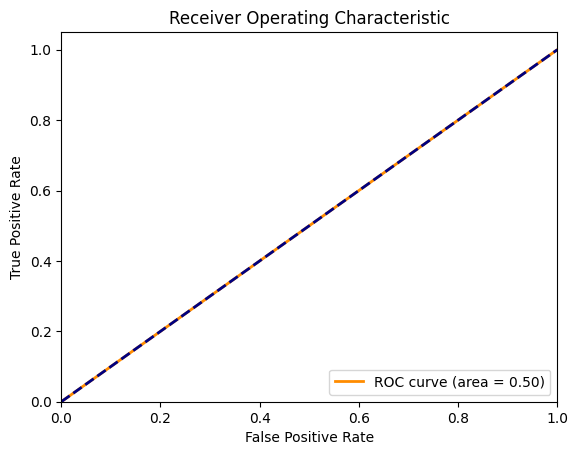

In [44]:
gru_test_model(model, test_loader)

In [46]:
forward_train_loader, forward_val_loader, forward_test_loader = get_data_loader(forward_dataset, merged_df)

In [ ]:
gru_train_model(forward_train_loader, forward_val_loader)

Epoch 1/10
Train Loss: 0.7999 | Train Accuracy: 0.86
Validation Loss: 0.7173 | Validation Accuracy: 0.85
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Loss: 0.7031 | Train Accuracy: 0.86
Validation Loss: 0.6970 | Validation Accuracy: 0.85
Epoch 3/10
Train Loss: 0.6957 | Train Accuracy: 0.86
Validation Loss: 0.6948 | Validation Accuracy: 0.85
Epoch 4/10
Train Loss: 0.6944 | Train Accuracy: 0.86
Validation Loss: 0.6941 | Validation Accuracy: 0.85
Epoch 5/10
Train Loss: 0.6940 | Train Accuracy: 0.86
Validation Loss: 0.6938 | Validation Accuracy: 0.85
Epoch 6/10
Train Loss: 0.6937 | Train Accuracy: 0.86
Validation Loss: 0.6936 | Validation Accuracy: 0.85
Epoch 7/10
Train Loss: 0.6936 | Train Accuracy: 0.86
Validation Loss: 0.6935 | Validation Accuracy: 0.85
Epoch 8/10
Train Loss: 0.6935 | Train Accuracy: 0.86
Validation Loss: 0.6935 | Validation Accuracy: 0.85
Epoch 9/10
Train Loss: 0.6935 | Train Accuracy: 0.86
Validation Loss: 0.6934 | Validation Accuracy: 0.85
Epoch 10/10
Train Loss: 0.6934 | Train Accuracy: 0.86
Validation Loss: 0.6934 | Validation Accuracy: 0.85


Test Accuracy: 0.8538
AUROC Score: 0.5124
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.85      1.00      0.92      1366
     Class 1       0.00      0.00      0.00       234

    accuracy                           0.85      1600
   macro avg       0.43      0.50      0.46      1600
weighted avg       0.73      0.85      0.79      1600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


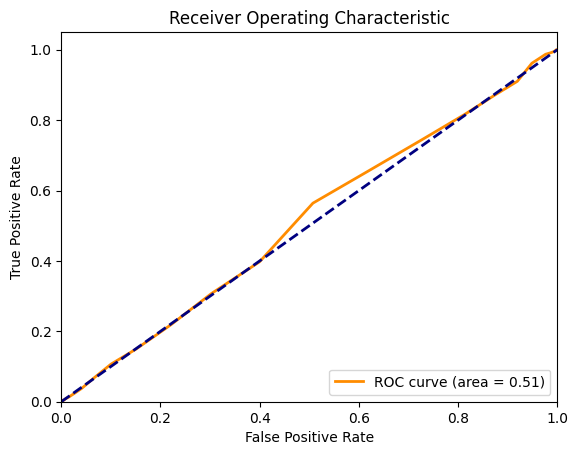

In [ ]:
gru_test_model(model, forward_test_loader)

In [60]:
mice_train_loader, mice_val_loader, mice_test_loader = get_data_loader(mice_dataset, labels_df)
gru_train_model(mice_train_loader, mice_val_loader)

Epoch 1/3
Train Loss: 0.6931 | Train Accuracy: 0.86
Validation Loss: 0.6931 | Validation Accuracy: 0.86
Epoch 2/3


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Loss: 0.6931 | Train Accuracy: 0.86
Validation Loss: 0.6931 | Validation Accuracy: 0.86
Epoch 3/3
Train Loss: 0.6931 | Train Accuracy: 0.86
Validation Loss: 0.6931 | Validation Accuracy: 0.86


In [ ]:
gru_test_model(model, mice_test_loader)

In [ ]:
mice_train_loader, mice_val_loader, mice_test_loader = get_data_loader(mice_dataset, labels_df)
gru_train_model(mice_train_loader, mice_val_loader)

Epoch 1/10
Train Loss: 0.7940 | Train Accuracy: 0.85
Validation Loss: 0.7201 | Validation Accuracy: 0.87
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Loss: 0.7038 | Train Accuracy: 0.85
Validation Loss: 0.6978 | Validation Accuracy: 0.87
Epoch 3/10
Train Loss: 0.6960 | Train Accuracy: 0.85
Validation Loss: 0.6951 | Validation Accuracy: 0.87
Epoch 4/10
Train Loss: 0.6946 | Train Accuracy: 0.85
Validation Loss: 0.6943 | Validation Accuracy: 0.87
Epoch 5/10
Train Loss: 0.6941 | Train Accuracy: 0.85
Validation Loss: 0.6939 | Validation Accuracy: 0.87
Epoch 6/10
Train Loss: 0.6938 | Train Accuracy: 0.85
Validation Loss: 0.6937 | Validation Accuracy: 0.87
Epoch 7/10
Train Loss: 0.6936 | Train Accuracy: 0.85
Validation Loss: 0.6936 | Validation Accuracy: 0.87
Epoch 8/10
Train Loss: 0.6935 | Train Accuracy: 0.85
Validation Loss: 0.6935 | Validation Accuracy: 0.87
Epoch 9/10
Train Loss: 0.6935 | Train Accuracy: 0.85
Validation Loss: 0.6935 | Validation Accuracy: 0.87
Epoch 10/10
Train Loss: 0.6934 | Train Accuracy: 0.85
Validation Loss: 0.6934 | Validation Accuracy: 0.87


Test Accuracy: 0.8562
AUROC Score: 0.4928
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.86      1.00      0.92      1370
     Class 1       0.00      0.00      0.00       230

    accuracy                           0.86      1600
   macro avg       0.43      0.50      0.46      1600
weighted avg       0.73      0.86      0.79      1600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


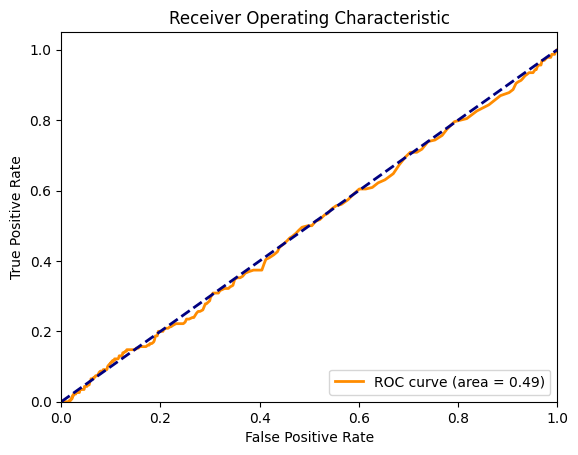

In [ ]:
gru_test_model(model, mice_test_loader)